# Project 2

## MSDS7331: Data Mining
## Section 0403
## Summer 2018
- Anthony Schams
- Laura Ludwig  
- David Stroud
- Joshua Balson

## Data Preparation
### Define and Prepare Class Variables

#### Import the data

In [96]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import datetime as dt
import warnings
import string
from sklearn.feature_extraction.text import TfidfVectorizer

df_train = pd.read_csv('train.csv')
df_resources = pd.read_csv('resources.csv')
train_resource = pd.merge(df_train, df_resources, on="id", how='left')
df_train[df_train.teacher_prefix.isnull()]
train_resource[train_resource.description.isnull()].head()
t2 = train_resource.pivot_table(index = ['id', 'description'],
                                values='quantity', 
                                aggfunc=np.sum)
t2.reset_index(inplace=True)
train_resource = pd.merge(train_resource,
                          t2, 
                          on=['id', 'description'], 
                          how='right',
                          suffixes=('_Orig', '_True'))

train_resource = train_resource.drop_duplicates()
train_resource = train_resource.drop('quantity_Orig', axis=1)
train_resource = train_resource.rename(columns={'quantity_True': 'True_Quantity'})
train_resource['Total_Cost'] = train_resource.price * train_resource.True_Quantity
Total_cost = train_resource.pivot_table(values=['Total_Cost','True_Quantity'],
                                        index='id',
                                        aggfunc={'Total_Cost' : np.sum, 'True_Quantity' : np.sum})
Total_cost.reset_index(level=0, inplace = True)

df_train = df_train.merge(Total_cost, on='id', how='left')
df_train['Average_item_cost'] = df_train.Total_Cost  / df_train.True_Quantity

df_train['text'] = df_train.apply(lambda row: ' '.join([str(row['project_essay_1']), 
                                                        str(row['project_essay_2']), 
                                                        str(row['project_essay_3']), 
                                                        str(row['project_essay_4'])]), axis=1
                                                      )                               

df = df_train

stop_words = list(set(stopwords.words('english')))
warnings.filterwarnings('ignore')
punctuation = string.punctuation

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182080 entries, 0 to 182079
Data columns (total 20 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

#### Variable Clean-up

We remove essays three and four since they were discontinued shortly after the time period of this analysis.  This is where we also add in the essay word lengths for essays one and two.  We perform a log transform on the continuous variables to correct for right-skew.  Finally, we create dummy variables for 'teacher_prefix' and 'project_grade_category'.

In [97]:
#https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
from __future__ import print_function

df["three_r"] = np.logical_or(df["project_subject_categories"].str.contains("Literacy & Language")
                             ,df["project_subject_categories"].str.contains("Math & Science")
                             )

# Remove attributes that arent useful
if 'project_essay_3' in df:
    del df['project_essay_3']
if 'project_essay_4' in df:    
    del df['project_essay_4']

# drop rows that still had missing values after grouped imputation
df.dropna(inplace=True)

# extract length of each essay and title
df['essay1_DescribeStudents_len'] = df['project_essay_1'].apply(len)
df['essay2_AboutProject_len'] = df['project_essay_2'].apply(len)
df['title_len'] = df['project_title'].apply(len)

# take natural log of right skewed attributes
df['teacher_number_of_previously_posted_projects']=np.log1p(df.teacher_number_of_previously_posted_projects)
df['Total_Cost']=np.log1p(df.Total_Cost)
df['True_Quantity']=np.log1p(df.True_Quantity)
df['Average_item_cost']=np.log1p(df.Average_item_cost)
df['essay1_DescribeStudents_len']=np.log1p(df.essay1_DescribeStudents_len)
df['essay2_AboutProject_len']=np.log1p(df.essay2_AboutProject_len)
df['title_len']=np.log1p(df.title_len)

# perform one-hot encoding of the categorical data
tmp_df = pd.get_dummies(df.teacher_prefix,prefix='teacher_prefix')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.project_grade_category,prefix='project_grade_category')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Keep these attributes
df = df[['teacher_number_of_previously_posted_projects','Total_Cost','True_Quantity','Average_item_cost','project_is_approved'
        ,'teacher_prefix_Teacher','project_grade_category_Grades PreK-2'
        ,'essay1_DescribeStudents_len','essay2_AboutProject_len','title_len','text'
        ,'three_r']]

# preserve final dataset
df2 = df
    
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182073 entries, 0 to 182079
Data columns (total 12 columns):
teacher_number_of_previously_posted_projects    182073 non-null float64
Total_Cost                                      182073 non-null float64
True_Quantity                                   182073 non-null float64
Average_item_cost                               182073 non-null float64
project_is_approved                             182073 non-null int64
teacher_prefix_Teacher                          182073 non-null uint8
project_grade_category_Grades PreK-2            182073 non-null uint8
essay1_DescribeStudents_len                     182073 non-null float64
essay2_AboutProject_len                         182073 non-null float64
title_len                                       182073 non-null float64
text                                            182073 non-null object
three_r                                         182073 non-null bool
dtypes: bool(1), float64(7), int64(

,teacher_number_of_previously_posted_projects,Total_Cost,True_Quantity,Average_item_cost,project_is_approved,teacher_prefix_Teacher,project_grade_category_Grades PreK-2,essay1_DescribeStudents_len,essay2_AboutProject_len,title_len
count,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000
mean,1.440580,6.021158,2.330753,3.916123,0.847676,0.021486,0.405821,6.447078,6.674833,3.429738
std,1.318374,0.740747,1.039543,1.282055,0.359335,0.144998,0.491052,0.335587,0.314533,0.407495
min,0.000000,4.313212,0.693147,0.230229,0.000000,0.000000,0.000000,3.931826,5.517453,1.609438
25%,0.000000,5.514759,1.609438,2.891869,1.000000,0.000000,0.000000,6.246107,6.458338,3.135494
50%,1.098612,5.990964,2.302585,3.848531,1.000000,0.000000,0.000000,6.406880,6.595781,3.433987
75%,2.302585,6.549365,3.091042,4.918228,1.000000,0.000000,1.000000,6.663133,6.858565,3.737670
max,6.113682,9.700169,7.247793,9.210340,1.000000,1.000000,1.000000,7.923348,8.561210,4.955827


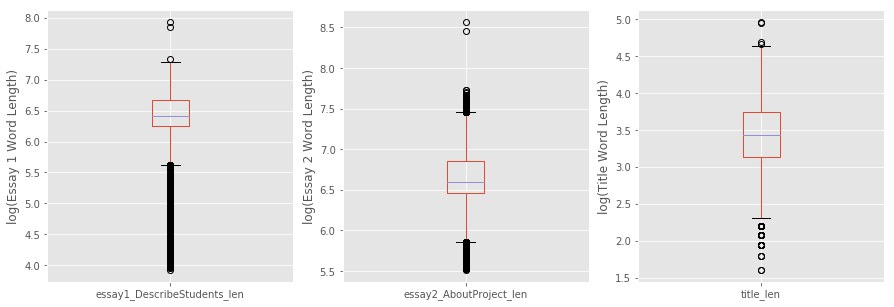

In [82]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
df.essay1_DescribeStudents_len.plot(kind='box')
plt.ylabel('log(Essay 1 Word Length)')
plt.subplot(1,3,2)
df.essay2_AboutProject_len.plot(kind='box')
plt.ylabel('log(Essay 2 Word Length)')
plt.subplot(1,3,3)
df.title_len.plot(kind='box')
plt.ylabel('log(Title Word Length)')
plt.show()

The boxplots above show the three new features added to this data set after the log transform has been applied

### Describing the Final Dataset

In [23]:
# Need description here, maybe a few visualizations

## Modeling and Evaluation

### Evaluation Metrics

In [26]:
#need something here

### Training and Testing Splits

In [28]:
#need something here

### Classification/Regression Models
We will create three different models for two different tasks.

-Task1:  predict whether an application will be approved or declined

-Task2:  predict whether an application project is one of the three Rs (Reading, Writing, Arithmetic) based on the essay text

#### Task 1:  Logistic Regression Model

In [100]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

if 'text' in df:
         del df['text'] # get rid of this for now
    

# we want to predict the X and y data as follows:
if 'project_is_approved' in df:
    y = df['project_is_approved'].values # get the labels we want
    del df['project_is_approved'] # get rid of the class label
    X = df.values # use everything else to predict!
    
#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced'] #,'none']
              ,'random_state': [0]
              ,'solver': ['sag'] #['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   35.2s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:  3.8min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced'], 'random_state': [0], 'solver': ['sag'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [101]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
#Display the best estimator parameters
regGridSearch.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)

In [102]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X, y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X, y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(y,predictions)
    confMat = confusion_matrix(y,predictions)
    acc = accuracy_score(y,predictions)
    
    print(classReport)
    print(confMat)
    print(acc)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X, y, cv)

The average accuracy for all cv folds is: 			 0.58346
The average precision for all cv folds is: 			 0.89174
The average recall for all cv folds is: 			 0.57965
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.582546,0.891846,0.578607
1,0.584963,0.895812,0.578433
2,0.577658,0.887019,0.574394
3,0.590180,0.896037,0.585837
4,0.576779,0.891567,0.571364
5,0.590400,0.890734,0.588216
6,0.579690,0.886203,0.577831
7,0.582931,0.893587,0.578550
8,0.589906,0.892640,0.588015
9,0.579580,0.891938,0.575249


In [103]:
EvaluateClassifierEstimator2(classifierEst, X, y, 10)

             precision    recall  f1-score   support

          0       0.21      0.61      0.31     27734
          1       0.89      0.58      0.70    154339

avg / total       0.79      0.58      0.64    182073

[[16917 10817]
 [64881 89458]]
0.584243682479


In [104]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
lr_clf = LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='sag', tol=0.0001, verbose=0, warm_start=False) # get object

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)
====Iteration 0  ====
accuracy 0.582617053412
confusion matrix
 [[ 3347  2169]
 [13030 17869]]
====Iteration 1  ====
accuracy 0.58838390773
confusion matrix
 [[ 3433  2122]
 [12867 17993]]
====Iteration 2  ====
accuracy 0.585912398737
confusion matrix
 [[ 3398  2205]
 [12874 17938]]


In [105]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
from sklearn.preprocessing import StandardScaler

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)  
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.520884250995
[[ 4827  6093]
 [11354 14141]]
Total_Cost has weight of -0.297757791811
essay1_DescribeStudents_len has weight of -0.0718774402209
project_grade_category_Grades PreK-2 has weight of -0.0377430264034
teacher_prefix_Teacher has weight of -0.0327864057264
title_len has weight of 0.0271938047901
True_Quantity has weight of 0.0441839348485
teacher_number_of_previously_posted_projects has weight of 0.209985707581
essay2_AboutProject_len has weight of 0.264245384032
Average_item_cost has weight of 0.381963606147


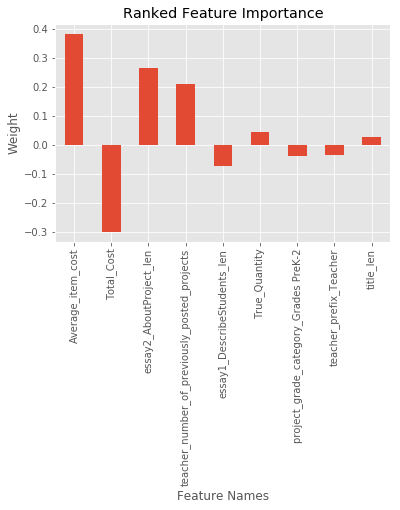

In [106]:
# now let's make a pandas Series with the names and values, and plot them
# reference for code: https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = lr_clf.coef_.ravel()
feature_names = df.columns.values

logreg_features = pd.DataFrame({'feature_names': feature_names[:9], 'weights': weights, 'absolute_weights':np.abs(weights)})
logreg_features.sort_values(by='absolute_weights', inplace=True, ascending = False)

weights = pd.Series(logreg_features['weights'].values, index=logreg_features['feature_names'])
px = weights.plot(kind='bar')
px.set_xlabel("Feature Names")
px.set_ylabel("Weight")
px.set_title("Ranked Feature Importance")
plt.show()

#### Naive Bayes - Multinomial

In [107]:
#need to split these out (task 1 and task 2 models) and also add in the other variables besides text

In [99]:
#reset dataframe to original state
df = df2
    
train = df.sample(frac=0.8,random_state=200)
test =df.sample(frac = 0.2, random_state = 201)

y_proj_train = train['project_is_approved']
y_proj_test = test['project_is_approved']

if 'project_is_approved' in train: del train['project_is_approved']
if 'project_is_approved' in test: del test['project_is_approved']
    
# Create and fit our Tfidf Vectorizer
vectorizer = TfidfVectorizer()
text = vectorizer.fit_transform(train['text'])

# Grab the Three R's column as our testing variable.
y = train['three_r']
x_test = vectorizer.transform(test['text'])
y_test = test['three_r']

mnb = MultinomialNB()
mnb.fit(text, y)
mnb.predict(x_test)

mnb_proj = MultinomialNB()
mnb_proj.fit(text, y_proj_train)
mnb_proj.predict(x_test)

print("Accuracy of a Multinomial NB classifier on the Three R's column:",
      accuracy_score(mnb.predict(x_test), y_test))

print("Accuracy of a Multinomial NB classifier on the project approval column:",
      accuracy_score(mnb_proj.predict(x_test), y_test))

Accuracy of a Multinomial NB classifier on the Three R's column: 0.834710970754
Accuracy of a Multinomial NB classifier on the project approval column: 0.699958808183


### Analyze Results of Chosen Models

In [ ]:
#need something here

### Model Advantages

In [ ]:
#need something here

### Model Attribute Importance

In [78]:
#need something here

## Deployment

In [ ]:
#need something here

## Exceptional Work

In [79]:
#need something here